# 1. Introduction

Project: Enron Fraud Prediction

Author: Mai Aye

This IPython Notebook explores Enron's data set and then identifies persons of interest (POI's) for fraud using machine learning algorithms.  The data set is provided by Udacity as part of the Data Analyst Nanodegree program.  

The Enron data set contains 146 records.  Each record consists of a POI or a non-POI and his or her financial and email information.  I will use precision/recall to evaluate the performances of machine learning models used to predict POI's. Recall is a metric that indicates how many POI's are correctly flagged as POI's by the models, while precision entails the probability of POI's being actually POI's when the models flag them as POI's.  Because we want to be able to flag all POI's for further investigation, a model with the highest recall for the POI's would be the most ideal.  I will use logistic regression and random forest classifiers and tune their respective parameters to best predict POI's.  

In [2]:
#importing necessary modules and libraries
import sys
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from clean_data import *
from visualize import *
from build_model import *
from tester import *
import matplotlib.pyplot as plt

 (Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=18, score_func=<function f_classif at 0x000000000C3289E8>)), ('logistic_regression', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]), {'METTS MARK': {'to_messages': 807.0, 'deferral_payments': 0.0, 'expenses': 94299.0, 'poi': 0.0, 'stock_ratio': 0.0, 'deferred_income': 0.0, 'long_term_incentive': 0.0, 'restricted_stock_deferred': 0.0, 'shared_receipt_with_poi': 702.0, 'loan_advances': 0.0, 'from_messages': 29.0, 'other': 1740.0, 'to_poi_ratio': 0.034482758, 'director_fees': 0.0, 'shared_receipt_ratio': 0.86988848, 'bonus': 600000.0, 'total_stock_value': 585062.0, 'from_poi_to_this_person': 38.0, 'from_this_person_to_poi': 1.0, 'from_poi_ratio': 0.047087979

# 2. Data Cleaning and Exploration


In [3]:
#Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#Transform dictionary into pandas
data = pd.DataFrame.from_dict(data_dict, orient = "index")

#Setting index name of pandas data frame to POI's name
data.index.name = "Name"

#remove irrelevant fields like emails
data.drop(["email_address"], inplace=True,axis=1)

#convert columns from objects to float
for col in data.columns:
    if data[col].dtype == object:
        data[col] = data[col].astype("float64")
        


Before imputing for missing values in each feature, we must look at each record or row to determine if there are any POI's with little to no financial and/or email data.  

In [4]:
#Getting the median number of missing values in rows 
med = np.median(data.isnull().sum(axis = 1).tolist())
print med

#Add a column to data frame that keeps track of the number of missing values in each row
data["missing_num"] = data.isnull().sum(axis = 1)


9.0


The median number of missing values for the rows in the data set is 9. Let's look at data where the number of missing values in rows greatly exceeds the median.

In [5]:
print "Number of columns is: ", len(data.columns)
print "Total number of records: ", len(data) 
print "Total number of records exceeding the median number of missing values: ",len(data.loc[data["missing_num"] > med])

Number of columns is:  21
Total number of records:  146
Total number of records exceeding the median number of missing values:  68


We have a small data set so we cannot remove all 68 records with missing values. Let's look for POI's who have little to no records.I set the maximum number of missing records to 15.   

In [6]:
for i in data[data["missing_num"] >15].index.tolist():
    print i


CHRISTODOULOU DIOMEDES
CLINE KENNETH W
GILLIS JOHN
GRAMM WENDY L
LOCKHART EUGENE E
SAVAGE FRANK
SCRIMSHAW MATTHEW
THE TRAVEL AGENCY IN THE PARK
WAKEHAM JOHN
WHALEY DAVID A
WODRASKA JOHN
WROBEL BRUCE


In [7]:
missing_list = data[data["missing_num"] >15].index.tolist()
    
for row in data.ix[missing_list].iterrows():
    print "----------------------------------------------------"
    print row
    

----------------------------------------------------
('CHRISTODOULOU DIOMEDES', salary                               NaN
to_messages                          NaN
deferral_payments                    NaN
total_payments                       NaN
exercised_stock_options      5.12716e+06
bonus                                NaN
restricted_stock                  950730
shared_receipt_with_poi              NaN
restricted_stock_deferred            NaN
total_stock_value            6.07788e+06
expenses                             NaN
loan_advances                        NaN
from_messages                        NaN
other                                NaN
from_this_person_to_poi              NaN
poi                                False
director_fees                        NaN
deferred_income                      NaN
long_term_incentive                  NaN
from_poi_to_this_person              NaN
missing_num                           16
Name: CHRISTODOULOU DIOMEDES, dtype: object)
--------------

Eugene E Lockhart has no records whatsoever, so I remove him from the data set.

In [8]:
#removing Eugene E. Lockhart from the data set
data = data[data.index != "LOCKHART EUGENE E"]

Because missing values in financial data actually equal to zero per the accompanying PDF document, we impute these missing values as zeroes. 

In [9]:
# a list of all the features related to finance
finance_list = ["salary","deferral_payments","total_payments","exercised_stock_options","bonus","restricted_stock",
                "restricted_stock_deferred","total_stock_value","expenses","loan_advances","other","director_fees",
                "deferred_income","long_term_incentive"
               ]

In [10]:
# imputing finance features with 0
for i in finance_list:
    data[i].fillna(value = 0, inplace=True)

Now let's look at each feature and its corresponding number of missing values.

In [11]:
print data.apply(show_missing, axis=0)

salary                        0
to_messages                  59
deferral_payments             0
total_payments                0
exercised_stock_options       0
bonus                         0
restricted_stock              0
shared_receipt_with_poi      59
restricted_stock_deferred     0
total_stock_value             0
expenses                      0
loan_advances                 0
from_messages                59
other                         0
from_this_person_to_poi      59
poi                           0
director_fees                 0
deferred_income               0
long_term_incentive           0
from_poi_to_this_person      59
missing_num                   0
dtype: int64


Features related to email still have missing values, and these missing values are actually true missing values per the accompanying PDF document. Let's impute these features with their respective medians.  

In [12]:
email_list = ["to_messages","shared_receipt_with_poi","from_messages","from_this_person_to_poi","from_poi_to_this_person"]

In [13]:
#Replacing missing values in each field with the median
for i in email_list:
        data[i].fillna(data[i].median(), inplace = True)

#Printing data after replacing NAs
print data.apply(show_missing, axis=0)

salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
exercised_stock_options      0
bonus                        0
restricted_stock             0
shared_receipt_with_poi      0
restricted_stock_deferred    0
total_stock_value            0
expenses                     0
loan_advances                0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
director_fees                0
deferred_income              0
long_term_incentive          0
from_poi_to_this_person      0
missing_num                  0
dtype: int64


After replacing missing values, let's examine outliers through the IQR rule.

In [14]:
#Detecting erronous data entries in the POI's names via IQR and removing them
print show_error(data.index)

CHRISTODOULOU DIOMEDES
FOY JOE
PEREIRA PAULO V. FERRAZ
PIRO JIM
SULLIVAN-SHAKLOVITZ COLLEEN
THE TRAVEL AGENCY IN THE PARK
TOTAL
None


"TOTAL" is not a person's name, so I remove its corresponding records.

In [15]:
data = data[data.index != "TOTAL"]

I then examine outliers based on salary using the IQR rule.

In [16]:
outlier_data = return_outliers(data,'salary')

In [17]:
for i in outlier_data.index:
    print i

In [18]:
print len(outlier_data)

0


There are no outliers so far.  I then make a correlation matrix to examine the relationships between features.  

In [19]:
# Deleting the missing_num column
del data["missing_num"]

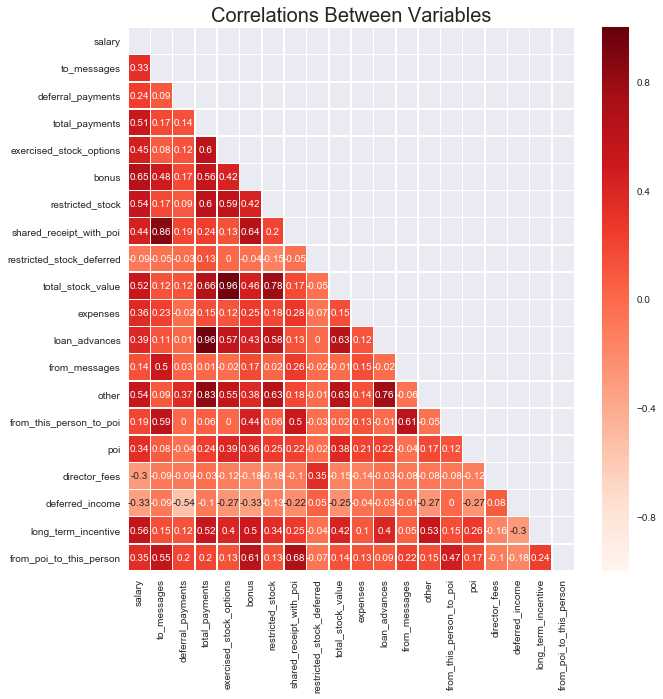

In [20]:
%matplotlib inline
make_corr_matrix(data, "corplot.png")

Based on the matrix above, we have notable features that are related to each other to a certain degree (at least by 0.60):  

   - 'bonus' and 'salary' by 0.65;  
   - 'to_messages' and 'shared_receipt_with_poi' are correlated by 0.86;   
   - 'total_payment' and 'exercised_stock_options' by 0.60;  
   - 'total_payment' and 'loan_advances' by 0.96;  
   - 'total_payment' and other by 0.83;  
   - 'exercised_stock_option' and 'total_stock_value' by 0.96;  
   - 'total_stock_value' and 'total_payment' by 0.66; and  
   - 'from_messages' and 'from_this_person_to_poi' by 0.61.

Knowing these correlated features will help us with feature engineering later in this notebook. Here are scatter plots demonstrating the linear relationships between some variables that are highly correlated to each other.


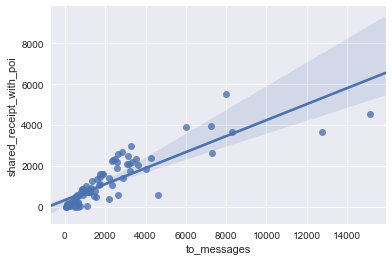

In [21]:
sns.regplot(x="to_messages", y="shared_receipt_with_poi", data = data);

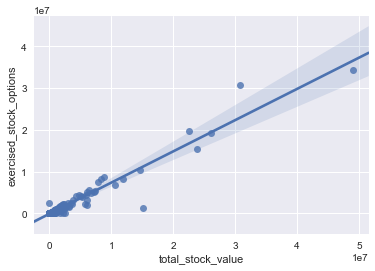

In [22]:
sns.regplot(x="total_stock_value", y="exercised_stock_options", data = data);

# 2. Feature Engineering

We can see from the visualizations above that certain features, such as 'to_messages' and 'shared_receipt_with_poi' are related.  However, these features alone do not demonstrate anything meaningful, and feature engineering, therefore, is needed.  A good indicator for a person being a POI is whether he/she sends to, receives to, and shares messages with POI's. However, the absolulete values in the features, 'from_this_person_to_poi', 'from_poi_to_this_person', and 'shared_receipt_with_poi' cannot really indicate anything meaningful.  We want to be able assess a person's email communication to POI's relative to a person's overall email communication, so I also represent these features as ratios:

   - from_poi_ratio = (from_poi_to_this_person / to_messages);  
   - shared_receipt_ratio = (shared_receipt_with_poi / to_messages); and
   - to_poi_ratio = (from_this_person_to_poi / from_messages).

In [23]:
#making  a new data set that includes the newly engineered features
cleaned_data = data.copy(deep = True)

In [24]:
cleaned_data["from_poi_ratio"] = cleaned_data["from_poi_to_this_person"]/cleaned_data["to_messages"]
cleaned_data["shared_receipt_ratio"] = cleaned_data["shared_receipt_with_poi"]/cleaned_data["to_messages"]
cleaned_data["to_poi_ratio"] = cleaned_data["from_this_person_to_poi"]/ cleaned_data["from_messages"]

How much a person's stocks are worth and whether he/she exercises stock options might also be good indicators for being a POI.  However, the absolute values regarding stock values do not tell us anything meaningful, so I compute a ratio:

In [25]:
cleaned_data["stock_ratio"] = cleaned_data["exercised_stock_options"]/cleaned_data["total_stock_value"]

Another good indicator of fraud could be how much a person's bonus is relative to his or her salary.  It's intuitive that highly-paid executives receive high amounts of bonuses compared to those with lower salaries.  However, if a person who isn't highly paid receives a bonus that's in the range of a highly-paid executive's bonus, then it's possible that he or she could be a person of interest.  However, the absolute values of bonuses and salaries alone don't indicate anything meaningful, so I compute a bonus to salary ratio:

   - bonus_ratio = (bonus/salary)

In [26]:
cleaned_data["bonus_ratio"] = cleaned_data["bonus"]/cleaned_data["salary"]

'total_payments' and 'total_stock_value' are correlated by 0.66 per the correlation matrix.  Employees with large amounts of stock values would also receive a lot of payments.  However, if an employee receives a lot of payments when his or her stock values are low, then he or she could be a person of interest.  The abosolute values of payments and stock values alone do not indicate anything meaningful, so I compute a payments to stock value ratio:

In [27]:
cleaned_data["payment_ratio"] = cleaned_data["total_payments"]/cleaned_data["total_stock_value"]

'total_payments' and 'loan_advances' are also highly correlated by 0.96.  Employees receiving numerous payments would also have large amounts of loan advances.  Other than those with large amounts of stock values, employees who do not have large amounts of loan advances but who do receive numerous payments, therefore, could be persons of interest. The absolute values of payments and loan advances do not indicate anything meaningful, so I compute a payments to loan advances  ratio:

In [28]:
cleaned_data["loan_ratio"] = cleaned_data["total_payments"]/cleaned_data["loan_advances"]

'total_stock_value' and 'restricted_stock' are correlated by 0.78.  Hence, employees with high total stock values would also have large amounts of restricted stocks.  The absolute values of total stock and restricted stock values don't tell us anything meanginful, so I compute a restricted stock to total stock value ratio:

In [29]:
cleaned_data["restricted_stock_ratio"] = cleaned_data["restricted_stock"]/cleaned_data["total_stock_value"]

'other', another finance-related feature, is also correlated to several finance-related features, such as 'loan_advances' and 'restricted_stock'.  On one hand, we don't really know what other entails.  All we know is that it's finance-related.  On the other hand, we can see from the correlation matrix that 'total_payments' has the highest correlation with other.  Other than those who receive numerous loan advances and stock payments, employees with numerous payments with low amounts of 'other' financial related payments could, therefore, be persons of interest.  The absolute values of other and total_payments don't indicate anything meaningful, so I compute a total payments to other ratio: 

In [30]:
cleaned_data["other_ratio"] = cleaned_data["total_payments"]/cleaned_data["other"]

In [31]:
#Pre-processing  the original data set without newly engineered features before scaling them    
data = data.convert_objects(convert_numeric=True)
data["poi"] = data["poi"].astype(float)

print data.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                          float64
director_fees                float64
deferred_income              float64
long_term_incentive          float64
from_poi_to_this_person      float64
dtype: object


Let's examine the missing values in the variables of the new data set engineered features.

In [32]:
print cleaned_data.columns[cleaned_data.isnull().any()]

Index([u'stock_ratio', u'bonus_ratio', u'payment_ratio', u'loan_ratio',
       u'restricted_stock_ratio', u'other_ratio'],
      dtype='object')


In [33]:
miss_list = ["stock_ratio", "bonus_ratio", "payment_ratio", "loan_ratio","restricted_stock_ratio","other_ratio"]

#print numbers of missing values for these fields
print  cleaned_data[miss_list].apply(show_missing, axis=0)

stock_ratio               18
bonus_ratio               50
payment_ratio              2
loan_ratio                20
restricted_stock_ratio    16
other_ratio               20
dtype: int64


These fields do not have a lot missing values for over 50% of their records, so I impute them using their respective median.

In [34]:
for i in miss_list:
        cleaned_data[i].fillna(cleaned_data[i].median(), inplace = True)

In [35]:
print cleaned_data.apply(show_missing, axis = 0)

salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
exercised_stock_options      0
bonus                        0
restricted_stock             0
shared_receipt_with_poi      0
restricted_stock_deferred    0
total_stock_value            0
expenses                     0
loan_advances                0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
director_fees                0
deferred_income              0
long_term_incentive          0
from_poi_to_this_person      0
from_poi_ratio               0
shared_receipt_ratio         0
to_poi_ratio                 0
stock_ratio                  0
bonus_ratio                  0
payment_ratio                0
loan_ratio                   0
restricted_stock_ratio       0
other_ratio                  0
dtype: int64


In [36]:
cleaned_data = cleaned_data.convert_objects(convert_numeric=True)
cleaned_data["poi"] = cleaned_data["poi"].astype(float)

print cleaned_data.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                          float64
director_fees                float64
deferred_income              float64
long_term_incentive          float64
from_poi_to_this_person      float64
from_poi_ratio               float64
shared_receipt_ratio         float64
to_poi_ratio                 float64
stock_ratio                  float64
bonus_ratio                  float64
payment_ratio                float64
loan_ratio                   float64
r

In [37]:
#Imputing for infinite values
cleaned_data[~np.isfinite(cleaned_data)] = np.nan
cleaned_data.isnull().sum()

salary                         0
to_messages                    0
deferral_payments              0
total_payments                 0
exercised_stock_options        0
bonus                          0
restricted_stock               0
shared_receipt_with_poi        0
restricted_stock_deferred      0
total_stock_value              0
expenses                       0
loan_advances                  0
from_messages                  0
other                          0
from_this_person_to_poi        0
poi                            0
director_fees                  0
deferred_income                0
long_term_incentive            0
from_poi_to_this_person        0
from_poi_ratio                 0
shared_receipt_ratio           0
to_poi_ratio                   0
stock_ratio                    1
bonus_ratio                    0
payment_ratio                 17
loan_ratio                   141
restricted_stock_ratio         3
other_ratio                   32
dtype: int64

Most of the records are in the 'loan_ratio' features are infinite or missing, so I remove this feature from the data set, while imputing the 'stock_ratio', 'payment_ratio', 'restricted_stock_ratio', and 'other_ratio' with their respective medians.

In [38]:
del cleaned_data["loan_ratio"]

In [39]:
inf_list = ["stock_ratio","payment_ratio","restricted_stock_ratio","other_ratio"]

for i in inf_list:
        cleaned_data[i].fillna(cleaned_data[i].median(), inplace = True)

cleaned_data.isnull().sum()

salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
exercised_stock_options      0
bonus                        0
restricted_stock             0
shared_receipt_with_poi      0
restricted_stock_deferred    0
total_stock_value            0
expenses                     0
loan_advances                0
from_messages                0
other                        0
from_this_person_to_poi      0
poi                          0
director_fees                0
deferred_income              0
long_term_incentive          0
from_poi_to_this_person      0
from_poi_ratio               0
shared_receipt_ratio         0
to_poi_ratio                 0
stock_ratio                  0
bonus_ratio                  0
payment_ratio                0
restricted_stock_ratio       0
other_ratio                  0
dtype: int64

In [40]:
#Pre-processing data set with newly engineered features   
for column in cleaned_data:
    cleaned_data[column] = cleaned_data[column].astype('float32')

print cleaned_data.dtypes

salary                       float32
to_messages                  float32
deferral_payments            float32
total_payments               float32
exercised_stock_options      float32
bonus                        float32
restricted_stock             float32
shared_receipt_with_poi      float32
restricted_stock_deferred    float32
total_stock_value            float32
expenses                     float32
loan_advances                float32
from_messages                float32
other                        float32
from_this_person_to_poi      float32
poi                          float32
director_fees                float32
deferred_income              float32
long_term_incentive          float32
from_poi_to_this_person      float32
from_poi_ratio               float32
shared_receipt_ratio         float32
to_poi_ratio                 float32
stock_ratio                  float32
bonus_ratio                  float32
payment_ratio                float32
restricted_stock_ratio       float32
o

I then split the data sets into training and testing sets.

In [41]:
#splitting the new data set with engineered features into training and testing sets
#from sklearn.cross_validation import train_test_split

cleaned_features = cleaned_data[['salary','to_messages','deferral_payments','total_payments','exercised_stock_options','bonus','restricted_stock','shared_receipt_with_poi','restricted_stock_deferred',
                                 'total_stock_value','expenses','loan_advances','from_messages','other',                       
                                'from_this_person_to_poi','director_fees','deferred_income','long_term_incentive','from_poi_to_this_person','from_poi_ratio',              
                                'shared_receipt_ratio','to_poi_ratio','stock_ratio','bonus_ratio','payment_ratio','restricted_stock_ratio','other_ratio'
                                ]]


cleaned_features_train, cleaned_features_test, cleaned_target_train, cleaned_target_test = train_test_split(cleaned_features, cleaned_data['poi'], random_state = 42)

In [42]:
#splitting the original data set into training and testing sets
features = data[['salary','to_messages','deferral_payments','total_payments','exercised_stock_options','bonus',
            'restricted_stock','shared_receipt_with_poi','restricted_stock_deferred','total_stock_value','expenses','loan_advances',
            'from_messages','other','from_this_person_to_poi','director_fees','deferred_income','long_term_incentive','from_poi_to_this_person' 
            ]]

features_train, features_test, target_train, target_test = train_test_split(features, data['poi'], random_state = 42)

# 3. Model Building and Selection

I'm using two data sets -- the original data and the new data set with engineered features -- in order to assess whether models with additional, engineered features perform better or not.  I pick logistic regression and random forest as my algorithms for the following reasons:  
- Our data set has binary variable of POI or non-POI, making logistic regression an appropriate classifier; and
- Most of the records in our data set overwhelmingly consist of non-POI's, and this class imbalance makes random forest an appropriate classifier.

Automatically tuning all possible combinations of parameters via Python GridSearch CV returns the best parameters for the models with the greatest performance. SelectKBest feature selection with a list of different numbers of features and PCA are tuned for both logistic regression and random forest.  

I tune the following parameters specifically for logistic regression:

- The 'C' parameter to reduce overfitting - a problem entailing the model predicting well on the training data but not on the unseen data; and
- The 'class_weight' in order to account for class imbalance.

I tune the following parameters specifically for random forest in order to reduce the risk of overfitting:
- The 'n_estimators' parameter that decides the best numbers of trees in the forest; and
- The 'min_samples_split' parameter that decides the best number of samples needed to split a decision node.

I also incorporate StratifiedShuffleSplit and 10-fold cross validation to further optimize model performance and also account for class imbalance.

## 3.1 Original Data Set

Let's use the original data set without the newly, engineered features.

In [43]:
#creating a dictionary of models and their names

#logistic regression models
l_param = logit_pipeline(features_train,target_train, val = False, p = False, f = False)
l_param_pca = logit_pipeline(features_train,target_train,val = False, p = True, f = False)
l_param_c = logit_pipeline(features_train,target_train,val = True, p = False, f = False)
l_param_pca_c = logit_pipeline(features_train,target_train,val = True, p = True, f = False)

#random forest
r_param = rf_pipeline(features_train,target_train, val= False, p = False, f = False)
r_param_pca = rf_pipeline(features_train,target_train, val= False, p=True, f = False)
r_param_c = rf_pipeline(features_train,target_train, val= True, p=False, f = False)
r_param_pca_c = rf_pipeline(features_train,target_train, val= True, p=True, f = False)


model_dict = {'logistic regression with SelectKBest feature selection and without cross validation':l_param,
             'logistic regression with PCA and without 10-fold cross validation': l_param_pca,
             'logistic regression with SelectKBest feature selection and 10-fold cross validation':l_param_c,
             'logistic regression with PCA and  10-fold cross validation':l_param_pca_c,
             'random forest with SelectKBest feature selection and without 10-fold cross validation':r_param,
             'random forest with PCA and without 10-fold cross validation':r_param_pca,
             'random forest with SelectKBest feature selection and with 10-fold cross validation':r_param_c,
             'random forest with PCA feature selection and with 10-fold cross validation':r_param_pca_c
             }


In [44]:
for key, value in model_dict.items():
    show_model_metrics(key,value,features_test,target_test)
    

Here are the results of  random forest with PCA feature selection and with 10-fold cross validation  :

             precision    recall  f1-score   support

        0.0       0.94      0.97      0.96        33
        1.0       0.50      0.33      0.40         3

avg / total       0.90      0.92      0.91        36

---------------------------------------------------------------------------------------------------------
Here are the results of  logistic regression with PCA and  10-fold cross validation  :

             precision    recall  f1-score   support

        0.0       0.96      0.82      0.89        33
        1.0       0.25      0.67      0.36         3

avg / total       0.90      0.81      0.84        36

---------------------------------------------------------------------------------------------------------
Here are the results of  random forest with SelectKBest feature selection and with 10-fold cross validation  :

             precision    recall  f1-score   support



## 3.2 Data Set with Engineered Features

Let's use the data set with the newly, engineered features.

In [45]:
#logistic regression
l_param_new = logit_pipeline(cleaned_features_train,cleaned_target_train, val = False, p = False, f = True)
l_param_new_pca = logit_pipeline(cleaned_features_train,cleaned_target_train, val = False, p = True, f = True)
l_param_new_c = logit_pipeline(cleaned_features_train,cleaned_target_train, val = True, p = False, f = True)
l_param_new_pca_c = logit_pipeline(cleaned_features_train,cleaned_target_train, val = True, p = True, f = True)

#random forest
r_param_new = rf_pipeline(cleaned_features_train,cleaned_target_train,val= False, p = False, f = True)
r_param_new_pca = rf_pipeline(cleaned_features_train,cleaned_target_train, val= False, p = True, f = True)
r_param_new_c = rf_pipeline(cleaned_features_train,cleaned_target_train, val= True, p = False, f = True)
r_param_new_pca_c = rf_pipeline(cleaned_features_train,cleaned_target_train, val= True, p = True, f = True)


model_dict = {'logistic regression with SelectKBest feature selection and without cross validation':l_param_new,
             'logistic regression with PCA and without 10-fold cross validation': l_param_new_pca,
             'logistic regression with SelectKBest feature selection and 10-fold cross validation':l_param_new_c,
             'logistic regression with PCA and  10-fold cross validation':l_param_new_pca_c,
             'random forest with SelectKBest feature selection and without 10-fold cross validation':r_param_new,
             'random forest with PCA and without 10-fold cross validation':r_param_new_pca,
             'random forest with SelectKBest feature selection and with 10-fold cross validation':r_param_new_c,
             'random forest with PCA feature selection and with 10-fold cross validation':r_param_new_pca_c
             }



In [46]:
for key, value in model_dict.items():
    show_model_metrics(key,value,cleaned_features_test,cleaned_target_test)

Here are the results of  random forest with PCA feature selection and with 10-fold cross validation  :

             precision    recall  f1-score   support

        0.0       0.94      0.97      0.96        33
        1.0       0.50      0.33      0.40         3

avg / total       0.90      0.92      0.91        36

---------------------------------------------------------------------------------------------------------
Here are the results of  logistic regression with PCA and  10-fold cross validation  :

             precision    recall  f1-score   support

        0.0       0.97      0.85      0.90        33
        1.0       0.29      0.67      0.40         3

avg / total       0.91      0.83      0.86        36

---------------------------------------------------------------------------------------------------------
Here are the results of  random forest with SelectKBest feature selection and with 10-fold cross validation  :

             precision    recall  f1-score   support



## 5. Results

The best models entails logistic regression using the data set with additional, engineered features.  
    
Because SelectKBest feature selection could be explained more intuitively, I pick the logistic regression with SelectKBest feature selection without cross validation using the data set with the additional, engineered features as the best model to predict fraud.  On one hand, this model captures 100% of true POI's for further investigation with a recall rate of 100% and a precision of 38%.  On the other hand, this model also protects innocent people, because its precision of 100% of non-POI's tells us that if a person is indeed flagged as innocent by the model, then the probability that he or she is actually innocent is 100%.    
    

Let's look at the top features for predicting for fraud.

In [47]:
#extracting top features' f1 scores
l_param_new = logit_pipeline(cleaned_features_train,cleaned_target_train,val = False, p = False, f = True)

top_feat = l_param_new.named_steps['feature_selection']

top_feat_fin = cleaned_features_train.columns[top_feat.transform(np.arange(len(cleaned_features_train.columns)))]

feature_str = ''.join(map(str,top_feat_fin))
feature_str = feature_str[feature_str.find('[') + len('['):feature_str.find(']')].strip().replace("'", '')

features_list = []

for word in feature_str.split(' '):
    features_list.append(word.strip())


In [48]:
all_features = {k: v for k, v in zip(list(cleaned_features_train.columns.values),  list(top_feat.scores_))}

In [49]:
sorted_features = sorted(all_features.iteritems(), key=lambda (k, v): (-v, k))[:18]

In [50]:
print "There are " , len(features_list), "features best predicting POI's.  Their names and their f-scores in descending order are:"

for i in sorted_features:
    print i

There are  18 features best predicting POI's.  Their names and their f-scores in descending order are:
('bonus', 24.08814492116527)
('salary', 17.137961131724083)
('total_stock_value', 15.140455618991563)
('exercised_stock_options', 15.087609266944277)
('to_poi_ratio', 10.95011129467825)
('deferred_income', 10.688007578135087)
('long_term_incentive', 8.9942042789970387)
('restricted_stock', 8.7283188797629219)
('shared_receipt_ratio', 8.4484452108156169)
('total_payments', 8.1240981820681064)
('shared_receipt_with_poi', 7.2937305960139174)
('bonus_ratio', 6.9626134591868274)
('loan_advances', 6.4538096774160065)
('expenses', 3.9406275943422804)
('other', 3.8703071301900827)
('from_poi_to_this_person', 3.1779558789106992)
('stock_ratio', 1.8511883381328507)
('director_fees', 1.7594640621876478)


Let's examine the coefficients of the logistic regression model itself.

In [51]:
logit_model = l_param_new.named_steps['logistic_regression']

In [52]:
#extracting coefficients from the logistic regression model
import math

coef_str = ''.join(map(str,logit_model.coef_))
coef_str = coef_str.replace('[','')
coef_str = coef_str.replace(']', '')

coef_list = []

for c in coef_str.split(' '):
    coef_list.append(c.strip())

coef_list = [c for c in coef_list if c]
coef_list = [float(c) for c in coef_list]

#expoteniating the coefficients to get the odd ratio's and then converting the odd ratio's to probabilities
coef_list_e = []
for c in coef_list:
    c = math.exp(c)/(1+math.exp(c))
    coef_list_e.append(c)

In [53]:
coefficients = {k: v for k, v in zip(features_list,  coef_list_e)}
print "Here are the features and their respective probabilities contributing to fraud: \n"
for i in sorted(coefficients.iteritems(), key=lambda (k, v): (-v, k)):
    print i

Here are the features and their respective probabilities contributing to fraud: 

('to_poi_ratio', 0.9895262184279959)
('exercised_stock_options', 0.9234633569407081)
('expenses', 0.8860684585309102)
('total_stock_value', 0.8710785845533553)
('salary', 0.7884964415017263)
('shared_receipt_ratio', 0.7597279015105216)
('bonus', 0.7409081017288377)
('shared_receipt_with_poi', 0.7098522409806279)
('bonus_ratio', 0.6960033707493709)
('restricted_stock', 0.5336599526562003)
('loan_advances', 0.4974459397146241)
('from_poi_to_this_person', 0.4653088355259344)
('long_term_incentive', 0.43514918394712737)
('total_payments', 0.369836095282112)
('other', 0.33139078900871083)
('director_fees', 0.1540219329202238)
('deferred_income', 0.1406584590802062)
('stock_ratio', 0.08482320546253408)


Based on the probabilities of the eighteen features, 'to_poi_ratio' (the number of emails to POI relative to the overall number of emails a person sends), 'excercised_stocked_options', 'expenses', 'total_stock_value', and 'salary' are the top five features with the highest probabilities leading to fraud.  

Unlike probabilities, the odd ratio's in logistic regression describe the constant effects that the features have on predicting fraud.  Hence, I also examine the odd ratio's in addition to probabilies.  

In [54]:
coef_list_o =[]

for c in coef_list:
    c = math.exp(c)
    coef_list_o.append(c)
    
coefficients_o = {k: v for k, v in zip(features_list,  coef_list_o)}

print "Here are the features and their respective odd ratio's contributing to fraud: \n"
for i in sorted(coefficients_o.iteritems(), key=lambda (k, v): (-v, k)):
    print i

Here are the features and their respective odd ratio's contributing to fraud: 

('to_poi_ratio', 94.4764994023695)
('exercised_stock_options', 12.065637059954584)
('expenses', 7.777200651421926)
('total_stock_value', 6.756663208633937)
('salary', 3.7280528379770104)
('shared_receipt_ratio', 3.1619480842208176)
('bonus', 2.8596343871525174)
('shared_receipt_with_poi', 2.4465198124560867)
('bonus_ratio', 2.289510158270713)
('restricted_stock', 1.144357975893008)
('loan_advances', 0.9898356794334698)
('from_poi_to_this_person', 0.8702384973644043)
('long_term_incentive', 0.7703789595063547)
('total_payments', 0.5868887324602958)
('other', 0.49564197375831287)
('director_fees', 0.18206374244652782)
('deferred_income', 0.16368167065408337)
('stock_ratio', 0.09268504836314613)


Based on the above-mentioned coefficients with odd ratio's that are greater than or equal to one:
- People who send more emails to POI's, as descirted by 'to_poi_ratio', are ~94 times more likley to commit fraud;
- People who exercise their stock options are ~12 times more likely to commit fraud; and
- People with high expenses, total stock values, and salaries are ~7.7 times, ~6.7 times, and ~3.7 times more likely to commit fraud, respectively.

Based on the above-mentioed coefficents with odd ratio's that are less than one, features like 'long_term_incentive', 'loan_advances' and 'defferred_income' decrease the chances of fraud.  For example, the chances of fraud decreases by ~77% with 'long_term_incentive'.  In other words, a person with long-term incentives in the company is probably less likely to commit fraud. 

I then pickle the best model and final data set.

In [55]:
features_list_fin = ['poi']+ features_list

In [56]:
with open('my_feature_list.pkl', 'wb') as f:
    pickle.dump(features_list_fin, f)

In [57]:
with open('my_classifier.pkl', 'wb') as c:
    pickle.dump(l_param_new, c)

In [58]:
cleaned_data["Employee"] = cleaned_data.index

cleaned_data.set_index("Employee", drop=True, inplace=True)
dictionary = cleaned_data.to_dict(orient = "index")

In [59]:
with open('my_dataset.pkl', 'wb') as d:
    pickle.dump(dictionary, d)

# 6. Limitations

I impute the missing values with the medians of their respective features.  Imputing missing values based using the median could add bias to the data set, especially if the data set has idiosyncratic values.  Therefore, a more sophisticated method of imputation, such as building separate models to predict the values of these missing values, may be needed.  In addition, sklearn doesn't produce confidence intervals for the coefficients, so confidence intervals should be calculated and examined to assess the reliability of the odd ratio's in predicting fraud.  

# 7. Sources

http://seaborn.pydata.org  
http://scikit-learn.org/stable/  
http://stackoverflow.com/  
http://www.theanalysisfactor.com/why-logistic-regression-for-binary-response/  
http://stats.idre.ucla.edu/stata/faq/how-do-i-interpret-odds-ratios-in-logistic-regression/  
http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/  
http://gchang.people.ysu.edu/class/mph/note/08_11_LogisticRegression.pdf  
https://www.civisanalytics.com/blog/  